# ***Perancangan Model Machine Learning***

**Import Library**

In [1]:
#Library 
import catboost as cb
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier, Pool
from scipy.stats import randint, uniform, loguniform
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree

**Load Data**

In [2]:
#Load Data
df = pd.read_csv(r'D:\python\code\CWRU\FIX\Fitur_Ekstraksi_FFT.csv')
print('Jumlah Baris      :', len(df.iloc[:,1]))
print('Jumlah Kolom      :', len(df.iloc[1,:]))
print(f'Terdapat {len(df.iloc[1,:-1])} Kolom Fitur dan {len(df.iloc[1,:1])} Kolom Target ({df.columns.tolist()[-1]}) pada Dataset')  # f-string
print('Fitur Data        :', df.columns.tolist()[:-1])
print('Kondisi Bearing   :', df['Fault'].unique())
pd.options.display.max_columns = None
df.head()

Jumlah Baris      : 2773
Jumlah Kolom      : 14
Terdapat 13 Kolom Fitur dan 1 Kolom Target (Fault) pada Dataset
Fitur Data        : ['Mean', 'Standard Deviation', 'Shape Factor', 'RMS', 'Peak to Peak', 'Kurtosis', 'Skewness', 'Impulse Factor', 'Crest Factor', 'Variance', 'Clearance Factor', 'Square Root Amplitude', 'Form Factor']
Kondisi Bearing   : ['BA_7' 'IR_7' 'OR1_7' 'OR2_7' 'OR3_7' 'BA_14' 'IR_14' 'OR1_14' 'BA_21'
 'IR_21' 'OR1_21' 'OR2_21' 'OR3_21' 'N']


,Mean,Standard Deviation,Shape Factor,RMS,Peak to Peak,Kurtosis,Skewness,Impulse Factor,Crest Factor,Variance,Clearance Factor,Square Root Amplitude,Form Factor,Fault
0,0.000175,0.000700,4.124014,0.000722,0.006978,45.340699,6.389996,73.391250,17.796070,4.900886e-07,9.676444,0.000722,4.124014,BA_7
1,0.000219,0.000894,4.199788,0.000921,0.010846,61.629437,7.076048,58.566598,13.945132,7.999201e-07,11.780684,0.000921,4.199788,BA_7
2,0.000180,0.000777,4.427641,0.000797,0.009023,67.525235,7.464275,71.306520,16.104857,6.033755e-07,11.317858,0.000797,4.427641,BA_7
3,0.000155,0.000665,4.398022,0.000682,0.006979,55.978306,7.004994,82.756033,18.816650,4.416734e-07,10.226512,0.000682,4.398022,BA_7
4,0.000219,0.000860,4.057768,0.000888,0.011739,88.986663,8.360051,58.704164,14.467106,7.400575e-07,13.233104,0.000888,4.057768,BA_7


***Simple Exploratory Data Analysis*** **(EDA)**

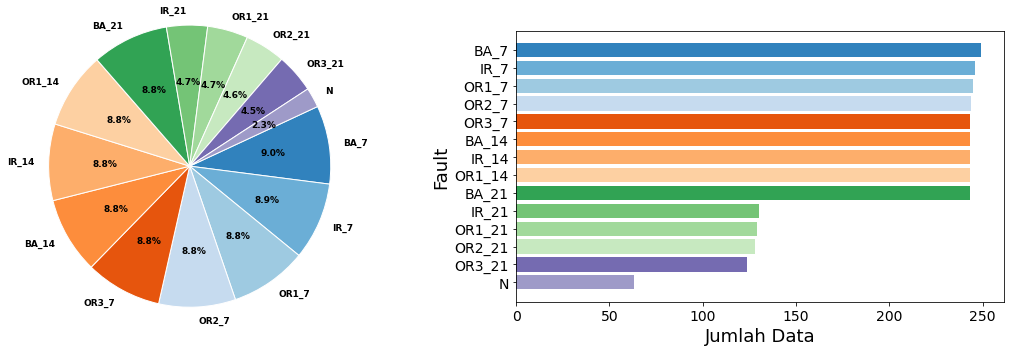

In [3]:
#Jumlah Persebaran Data
columns_failure_type = df['Fault'].unique().tolist()
# Plot pie chart 
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1) 
colors = plt.cm.tab20c(range(len(columns_failure_type))) 
plt.pie(df['Fault'].value_counts(),labels=columns_failure_type, autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'white'}, counterclock=False, shadow=False, startangle=25, 
        radius=1.3, textprops={'fontsize': 9, 'weight': 'bold'}, colors=colors) 

# Plot bar chart 
plt.subplot(1, 2, 2)  # Gunakan subplot kedua
plt.barh(columns_failure_type, df['Fault'].value_counts(), color=colors)  
plt.gca().invert_yaxis() 
plt.xlabel('Jumlah Data', fontsize=18)
plt.ylabel('Fault', fontsize=18)
ax = plt.gca()
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=14) 
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(columns_failure_type, fontsize=14)
plt.tight_layout()
plt.show()

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean,2773.0,8.556868e-05,6.155702e-05,1.643785e-05,3.464596e-05,6.963734e-05,1.242527e-04,0.000328
Standard Deviation,2773.0,2.959673e-04,2.129035e-04,4.040473e-05,1.070765e-04,2.949007e-04,3.739806e-04,0.001003
Shape Factor,2773.0,3.770653e+00,1.589120e+00,1.899117e+00,2.849869e+00,3.333822e+00,3.974475e+00,10.567348
RMS,2773.0,3.091615e-04,2.201243e-04,4.362047e-05,1.124125e-04,3.051497e-04,3.949846e-04,0.001054
Peak to Peak,2773.0,3.509538e-03,2.818943e-03,4.043287e-04,1.022152e-03,2.596885e-03,4.991143e-03,0.012836
Kurtosis,2773.0,8.818445e+01,1.189181e+02,9.210671e+00,2.940085e+01,4.314194e+01,7.157425e+01,479.305959
Skewness,2773.0,7.498486e+00,4.558163e+00,2.965821e+00,5.013308e+00,5.958597e+00,7.682609e+00,21.666619
Impulse Factor,2773.0,7.810309e+01,6.067152e+01,1.864723e+01,4.221963e+01,5.578188e+01,8.593835e+01,308.132539
Crest Factor,2773.0,1.951126e+01,1.018469e+01,8.037206e+00,1.329462e+01,1.605369e+01,2.362124e+01,78.515654
Variance,2773.0,1.329082e-07,1.859710e-07,1.632542e-09,1.146537e-08,8.696642e-08,1.398615e-07,0.000001


In [5]:
#Mendeteksi Nilai yang Hilang pada Setiap Kolom
df.isnull().sum()

Mean                     0
Standard Deviation       0
Shape Factor             0
RMS                      0
Peak to Peak             0
Kurtosis                 0
Skewness                 0
Impulse Factor           0
Crest Factor             0
Variance                 0
Clearance Factor         0
Square Root Amplitude    0
Form Factor              0
Fault                    0
dtype: int64

In [6]:
# Mengetahui Tipe Data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mean                   2773 non-null   float64
 1   Standard Deviation     2773 non-null   float64
 2   Shape Factor           2773 non-null   float64
 3   RMS                    2773 non-null   float64
 4   Peak to Peak           2773 non-null   float64
 5   Kurtosis               2773 non-null   float64
 6   Skewness               2773 non-null   float64
 7   Impulse Factor         2773 non-null   float64
 8   Crest Factor           2773 non-null   float64
 9   Variance               2773 non-null   float64
 10  Clearance Factor       2773 non-null   float64
 11  Square Root Amplitude  2773 non-null   float64
 12  Form Factor            2773 non-null   float64
 13  Fault                  2773 non-null   object 
dtypes: float64(13), object(1)
memory usage: 303.4+ KB


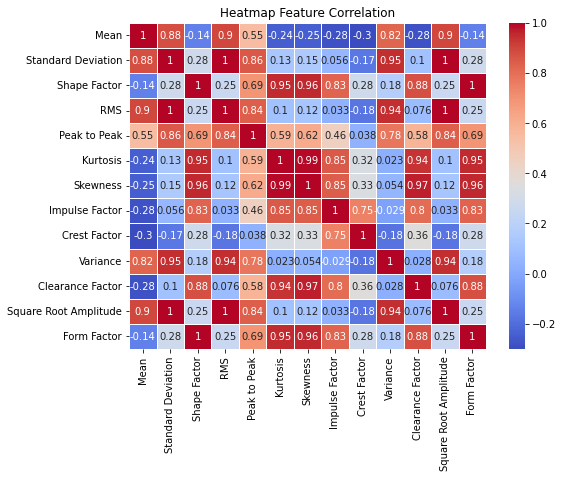

In [7]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Feature Correlation')
plt.show()

***Pre-Processing***

In [8]:
#Label Encoder untuk Mengganti Nilai Kategorik menjadi Numerik pada Variabel Target (Fault)
encoder = LabelEncoder()
df['Fault'] = encoder.fit_transform(df['Fault'])

label_enc_df = pd.DataFrame({'Kelas': encoder.classes_, 'Nilai Numerik': encoder.transform(encoder.classes_)})
label_enc_df

,Kelas,Nilai Numerik
0,BA_14,0
1,BA_21,1
2,BA_7,2
3,IR_14,3
4,IR_21,4
5,IR_7,5
6,N,6
7,OR1_14,7
8,OR1_21,8
9,OR1_7,9


***Splitting Data***

In [9]:
#Inisialisasi Fitur (X) dan Target (y)
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

print(X.shape)
print(y.shape)

(2773, 13)
(2773,)


In [10]:
#Splitting Data Training dan Data Testing
random_seed = 42
np.random.seed(random_seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_seed)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2218, 13) (555, 13)
(2218,) (555,)


**Decision Tree**

In [11]:
#Decision Tree without Parameter Tuning
seed_value = 42
np.random.seed(seed_value)
decision_tree = DecisionTreeClassifier(random_state=seed_value)
decision_tree.fit(X_train, y_train)

#Cross Valdiation (K-Fold)
cv = KFold(n_splits=5, shuffle=True)
Train_Accuracy_DT = cross_val_score(decision_tree, X_train, y_train, scoring='accuracy', cv=cv).mean()
Test_Accuracy_DT = cross_val_score(decision_tree, X, y, cv = cv).mean()
Precision_DT = cross_val_score(decision_tree, X, y, cv=cv, scoring='precision_macro').mean()
Recall_DT = cross_val_score(decision_tree, X, y, cv=cv, scoring='recall_macro').mean()
F1score_DT = cross_val_score(decision_tree, X, y, cv=cv, scoring='f1_macro').mean()
print(f"Training Accuracy_DecisionTree    : {Train_Accuracy_DT}")
print(f"Testing Accuracy_DecisionTree     : {Test_Accuracy_DT}")
print(f"Precision_DecisionTree            : {Precision_DT}")
print(f"Recall_DecisionTree               : {Recall_DT}")
print(f"F1-score_DecisionTree             : {F1score_DT}")

Training Accuracy_DecisionTree    : 0.9391332641896977
Testing Accuracy_DecisionTree     : 0.9473516115393371
Precision_DecisionTree            : 0.9093706436306774
Recall_DecisionTree               : 0.9148272012310027
F1-score_DecisionTree             : 0.9174825763621957


**Adaptive Boosting (AdaBoost)**

In [12]:
#Adaptive Boosting without Parameter Tuning
seed_value = 42
np.random.seed(seed_value)

#Define Base estimator (Decision Tree) with Default Parameter
base_estimator = DecisionTreeClassifier(ccp_alpha = 0.0,
                                        class_weight = None, 
                                        criterion = 'gini', 
                                        max_depth = None, 
                                        max_features = None, 
                                        max_leaf_nodes = None, 
                                        min_impurity_decrease = 0.0, 
                                        min_samples_leaf = 1, 
                                        min_samples_split =  2, 
                                        min_weight_fraction_leaf = 0.0, 
                                        random_state = 42, 
                                        splitter = 'best')
                                        
adaboost = AdaBoostClassifier(base_estimator=base_estimator, random_state=seed_value)
adaboost.fit(X_train, y_train)

#Cross Valdiation (K-Fold)
cv = KFold(n_splits=5, shuffle=True)
Train_Accuracy_ADB = cross_val_score(adaboost, X_train, y_train, scoring='accuracy', cv=cv).mean()
Test_Accuracy_ADB = cross_val_score(adaboost, X, y, cv = cv).mean()
Precision_ADB  = cross_val_score(adaboost, X, y, cv=cv, scoring='precision_macro').mean()
Recall_ADB  = cross_val_score(adaboost, X, y, cv=cv, scoring='recall_macro').mean()
F1score_ADB  = cross_val_score(adaboost, X, y, cv=cv, scoring='f1_macro').mean()
print(f"Training Accuracy_DecisionTree    : {Train_Accuracy_ADB}")
print(f"Testing Accuracy_DecisionTree     : {Test_Accuracy_ADB}")
print(f"Precision_DecisionTree            : {Precision_ADB}")
print(f"Recall_DecisionTree               : {Recall_ADB}")
print(f"F1-score_DecisionTree             : {F1score_ADB}")

Training Accuracy_DecisionTree    : 0.9404825819047037
Testing Accuracy_DecisionTree     : 0.9448264871369565
Precision_DecisionTree            : 0.9117128214672755
Recall_DecisionTree               : 0.9105270142540594
F1-score_DecisionTree             : 0.9119047226320893


**Gradient Boosting**

In [13]:
#Gradient Boosting without Parameter Tuning
seed_value = 42
np.random.seed(seed_value)
GBM = GradientBoostingClassifier(random_state=seed_value)
GBM.fit(X_train, y_train)

cv = KFold(n_splits=5, shuffle=True)
Train_Accuracy_GB = cross_val_score(GBM, X_train, y_train, scoring='accuracy', cv=cv).mean()
Test_Accuracy_GB = cross_val_score(GBM, X, y, cv = cv).mean()
Precision_GB = cross_val_score(GBM, X, y, cv=cv, scoring='precision_macro').mean()
Recall_GB = cross_val_score(GBM, X, y, cv=cv, scoring='recall_macro').mean()
F1score_GB = cross_val_score(GBM, X, y, cv=cv, scoring='f1_macro').mean()
print(f"Training Accuracy_LGBM     : {Train_Accuracy_GB}")
print(f"Testing Accuracy_LGBM      : {Test_Accuracy_GB}")
print(f"Precision_LGBM             : {Precision_GB}")
print(f"Recall_LGBM                : {Recall_GB}")
print(f"F1-score_LGBM              : {F1score_GB}")

Training Accuracy_LGBM     : 0.9558182335834706
Testing Accuracy_LGBM      : 0.9563606205483461
Precision_LGBM             : 0.9305601641651344
Recall_LGBM                : 0.928508436657102
F1-score_LGBM              : 0.9326905805634651


**Extreme Gradient Boosting (XGBoost)**

In [14]:
#XGBoost without Parameter Tuning
seed_value = 42
np.random.seed(seed_value)
xgboost = XGBClassifier(random_state=seed_value)
xgboost.fit(X_train, y_train)

#Cross Valdiation (K-Fold)
cv = KFold(n_splits=5, shuffle=True)
Train_Accuracy_XGB = cross_val_score(xgboost, X_train, y_train, scoring='accuracy', cv=cv).mean()
Test_Accuracy_XGB = cross_val_score(xgboost, X, y, cv = cv).mean()
Precision_XGB = cross_val_score(xgboost, X, y, cv=cv, scoring='precision_macro').mean()
Recall_XGB = cross_val_score(xgboost, X, y, cv=cv, scoring='recall_macro').mean()
F1score_XGB = cross_val_score(xgboost, X, y, cv=cv, scoring='f1_macro').mean()
print(f"Training Accuracy_XGBoost    : {Train_Accuracy_XGB}")
print(f"Testing Accuracy_XGBoost     : {Test_Accuracy_XGB}")
print(f"Precision_XGBoost            : {Precision_XGB}")
print(f"Recall_XGBoost               : {Recall_XGB}")
print(f"F1-score_XGBoost             : {F1score_XGB}")

Training Accuracy_XGBoost    : 0.9526528786122466
Testing Accuracy_XGBoost     : 0.9574423520993918
Precision_XGBoost            : 0.9393059376984182
Recall_XGBoost               : 0.931503215485779
F1-score_XGBoost             : 0.9309805440862234


**Categorical Boosting (CatBoost)**

In [15]:
#Categorical Boost without Parameter Tuning
seed_value = 42
np.random.seed(seed_value)
catboost = CatBoostClassifier(random_state=seed_value, verbose=0)
catboost.fit(X_train, y_train)

#Cross Valdiation (K-Fold)
cv = KFold(n_splits=5, shuffle=True)
Train_Accuracy_CTB = cross_val_score(catboost, X_train, y_train, scoring='accuracy', cv=cv).mean()
Test_Accuracy_CTB = cross_val_score(catboost, X, y, cv = cv).mean()
Precision_CTB = cross_val_score(catboost, X, y, cv=cv, scoring='precision_macro').mean()
Recall_CTB = cross_val_score(catboost, X, y, cv=cv, scoring='recall_macro').mean()
F1score_CTB = cross_val_score(catboost, X, y, cv=cv, scoring='f1_macro').mean()
print(f"Training Accuracy_CatBoost    : {Train_Accuracy_CTB}")
print(f"Testing Accuracy_CatBoost     : {Test_Accuracy_CTB}")
print(f"Precision_CatBoost            : {Precision_CTB}")
print(f"Recall_CatBoost               : {Recall_CTB}")
print(f"F1-score_CatBoost             : {F1score_CTB}")

Training Accuracy_CatBoost    : 0.9621235230716042
Testing Accuracy_CatBoost     : 0.96465541353628
Precision_CatBoost            : 0.9451786071729922
Recall_CatBoost               : 0.9374760163402929
F1-score_CatBoost             : 0.9369740030390918


**Histogram Gradient Boosting**

In [16]:
#Histogram Gradient Boosting without Parameter Tuning
seed_value = 42
np.random.seed(seed_value)
histboost = HistGradientBoostingClassifier(random_state=seed_value)
histboost.fit(X_train, y_train)

#Cross Valdiation (K-Fold)
cv = KFold(n_splits=5, shuffle=True)
Train_Accuracy_HTB = cross_val_score(histboost, X_train, y_train, scoring='accuracy', cv=cv).mean()
Test_Accuracy_HTB = cross_val_score(histboost, X, y, cv = cv).mean()
Precision_HTB = cross_val_score(histboost, X, y, cv=cv, scoring='precision_macro').mean()
Recall_HTB = cross_val_score(histboost, X, y, cv=cv, scoring='recall_macro').mean()
F1score_HTB = cross_val_score(histboost, X, y, cv=cv, scoring='f1_macro').mean()
print(f"Training Accuracy_HistBoost    : {Train_Accuracy_HTB}")
print(f"Testing Accuracy_HistBoost     : {Test_Accuracy_HTB}")
print(f"Precision_HistBoost            : {Precision_HTB}")
print(f"Recall_HistBoost               : {Recall_HTB}")
print(f"F1-score_HistBoost             : {F1score_HTB}")

Training Accuracy_HistBoost    : 0.9567150672116812
Testing Accuracy_HistBoost     : 0.9614121702930367
Precision_HistBoost            : 0.9400346989234665
Recall_HistBoost               : 0.9344815174657051
F1-score_HistBoost             : 0.9339449854786499


**Light Gradient Boosting**

In [17]:
#Light Gradient Boosting without Parameter Tuning
seed_value = 42
np.random.seed(seed_value)
lgbm = lgb.LGBMClassifier(random_state=seed_value)
lgbm.fit(X_train, y_train)

cv = KFold(n_splits=5, shuffle=True)
Train_Accuracy_LGB = cross_val_score(lgbm, X_train, y_train, scoring='accuracy', cv=cv).mean()
Test_Accuracy_LGB = cross_val_score(lgbm, X, y, cv = cv).mean()
Precision_LGB = cross_val_score(lgbm, X, y, cv=cv, scoring='precision_macro').mean()
Recall_LGB = cross_val_score(lgbm, X, y, cv=cv, scoring='recall_macro').mean()
F1score_LGB = cross_val_score(lgbm, X, y, cv=cv, scoring='f1_macro').mean()
print(f"Training Accuracy_LGBM     : {Train_Accuracy_LGB}")
print(f"Testing Accuracy_LGBM      : {Test_Accuracy_LGB}")
print(f"Precision_LGBM             : {Precision_LGB}")
print(f"Recall_LGBM                : {Recall_LGB}")
print(f"F1-score_LGBM              : {F1score_LGB}")


Training Accuracy_LGBM     : 0.9598682203648343
Testing Accuracy_LGBM      : 0.9624932513741177
Precision_LGBM             : 0.9400810826966669
Recall_LGBM                : 0.9345515752847071
F1-score_LGBM              : 0.9297697811168932


**Random Forest**

In [18]:
#Random Forest without Parameter Tuning
seed_value = 42
np.random.seed(seed_value)
random_forest = RandomForestClassifier(random_state=seed_value)
random_forest.fit(X_train, y_train)

cv = KFold(n_splits=5, shuffle=True)
Train_Accuracy_RF = cross_val_score(random_forest, X_train, y_train, scoring='accuracy', cv=cv).mean()
Test_Accuracy_RF = cross_val_score(random_forest, X, y, cv = cv).mean()
Precision_RF = cross_val_score(random_forest, X, y, cv=cv, scoring='precision_macro').mean()
Recall_RF = cross_val_score(random_forest, X, y, cv=cv, scoring='recall_macro').mean()
F1score_RF = cross_val_score(random_forest, X, y, cv=cv, scoring='f1_macro').mean()
print(f"Training Accuracy_LGBM     : {Train_Accuracy_RF}")
print(f"Testing Accuracy_LGBM      : {Test_Accuracy_RF}")
print(f"Precision_LGBM             : {Precision_RF}")
print(f"Recall_LGBM                : {Recall_RF}")
print(f"F1-score_LGBM              : {F1score_RF}")


Training Accuracy_LGBM     : 0.9517560449840359
Testing Accuracy_LGBM      : 0.9624945523140468
Precision_LGBM             : 0.9412591299191654
Recall_LGBM                : 0.9258867457238162
F1-score_LGBM              : 0.930706847999385


**Feature Importance**

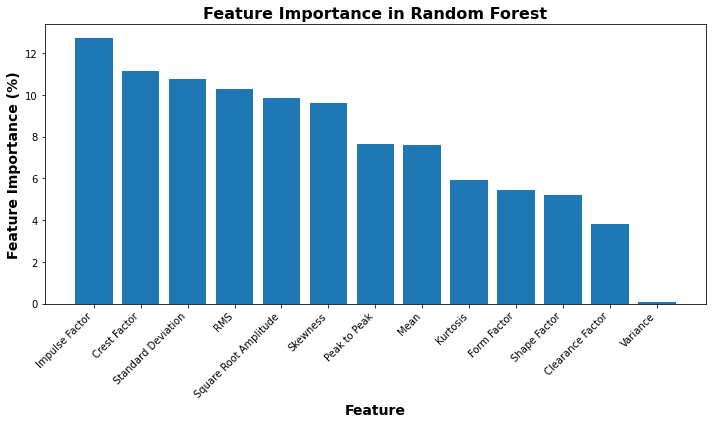

,Feature,Feature Importance
Rank,,
1,Impulse Factor,0.127336
2,Crest Factor,0.111482
3,Standard Deviation,0.107408
4,RMS,0.102726
5,Square Root Amplitude,0.098234
6,Skewness,0.095879
7,Peak to Peak,0.076284
8,Mean,0.076143
9,Kurtosis,0.059273


In [19]:
feature_names = df.columns[:-1]
fitur = ['Mean', 'Standard Deviation', 'Shape Factor', 'RMS', 'Peak to Peak',
                   'Kurtosis', 'Skewness', 'Impulse Factor', 'Crest Factor', 'Variance',
                   'Clearance Factor', 'Square Root Amplitude', 'Form Factor']

# Membuat daftar nama fitur sesuai urutan peringkat fitur
feature_importance = random_forest.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]
fitur_list = [fitur[i] for i in sorted_indices]

# Tampilkan hasil pemeringkatan
fitur = pd.DataFrame({'Feature': fitur_list, 'Feature Importance': feature_importance[sorted_indices]})
fitur.reset_index(drop=True, inplace=True)
fitur.index += 1
fitur.index.name = 'Rank'
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_indices] * 100)
plt.xticks(range(len(feature_importance)), np.array(feature_names)[sorted_indices], rotation=45, ha='right')
plt.xlabel("Feature", fontdict={'size': 14, 'weight': 'bold'})
plt.ylabel("Feature Importance (%)", fontdict={'size': 14, 'weight': 'bold'})
plt.title("Feature Importance in Random Forest", fontdict={'size': 16, 'weight': 'bold'})
plt.tight_layout()
plt.show()
fitur


In [20]:
#Comparison Performance Model
models = pd.DataFrame({
    'Model' : ['Decision Tree', 'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'Histogram Boosting', 'Light Gradient Boosting', 'Random Forest'],
    'Testing Accuracy' : [Test_Accuracy_DT, Test_Accuracy_ADB, Test_Accuracy_GB, Test_Accuracy_XGB, Test_Accuracy_CTB, Test_Accuracy_HTB, Test_Accuracy_LGB, Test_Accuracy_RF],
    'Training Accuracy' : [Train_Accuracy_DT, Train_Accuracy_ADB, Train_Accuracy_GB, Train_Accuracy_XGB, Train_Accuracy_CTB, Train_Accuracy_HTB, Train_Accuracy_LGB, Train_Accuracy_RF],
    'Precision' : [Precision_DT, Precision_ADB, Precision_GB, Precision_XGB, Precision_CTB, Precision_HTB, Precision_LGB, Precision_RF],
    'Recall' : [Recall_DT, Recall_ADB, Recall_GB, Recall_XGB, Recall_CTB, Recall_HTB, Recall_LGB, Recall_RF],
    'F1-Score' : [F1score_DT, F1score_ADB, F1score_GB, F1score_XGB, F1score_CTB, F1score_HTB, F1score_LGB, F1score_RF]
})
models.iloc[:, 1:] = models.iloc[:, 1:].mul(100)
models.sort_values(by = ['Testing Accuracy', 'Training Accuracy', 'Precision', 'Recall', 'F1-Score'])

,Model,Testing Accuracy,Training Accuracy,Precision,Recall,F1-Score
1,AdaBoost,94.482649,94.048258,91.171282,91.052701,91.190472
0,Decision Tree,94.735161,93.913326,90.937064,91.482720,91.748258
2,Gradient Boosting,95.636062,95.581823,93.056016,92.850844,93.269058
3,XGBoost,95.744235,95.265288,93.930594,93.150322,93.098054
5,Histogram Boosting,96.141217,95.671507,94.003470,93.448152,93.394499
6,Light Gradient Boosting,96.249325,95.986822,94.008108,93.455158,92.976978
7,Random Forest,96.249455,95.175604,94.125913,92.588675,93.070685
4,CatBoost,96.465541,96.212352,94.517861,93.747602,93.697400


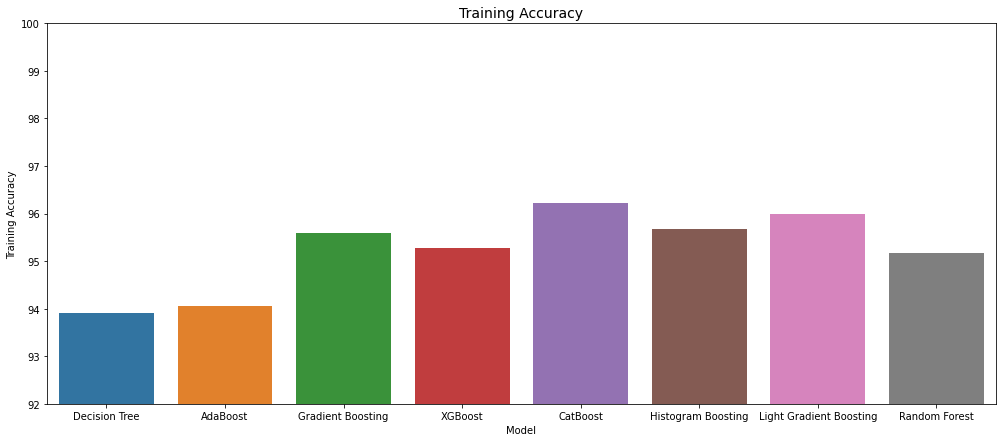

In [21]:
# Training Accuracy Comparison
plt.figure(figsize=(17,7))
sns.barplot(x='Model', y='Training Accuracy', data=models)
plt.title("Training Accuracy", fontsize=14)
plt.ylim(92,100)
plt.show()

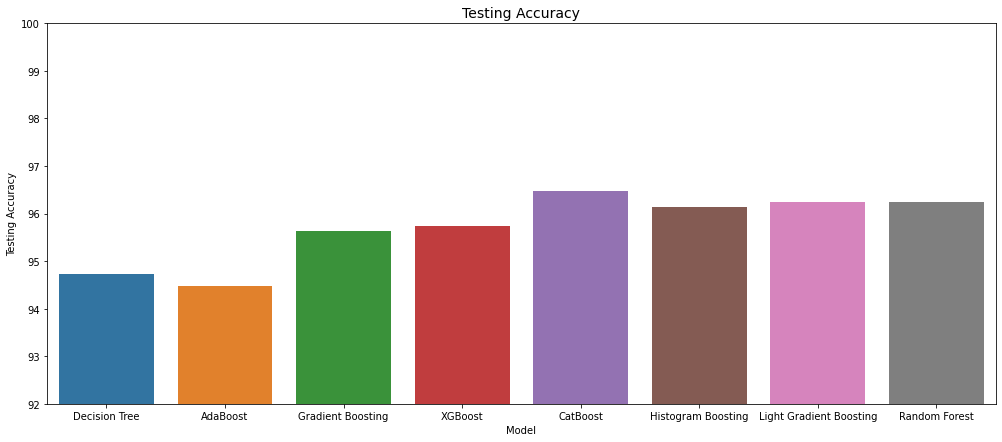

In [22]:
# Testing Accuracy Comparison
plt.figure(figsize=(17,7))
sns.barplot(x='Model', y='Testing Accuracy', data=models)
plt.title("Testing Accuracy", fontsize=14)
plt.ylim(92,100)
plt.show()

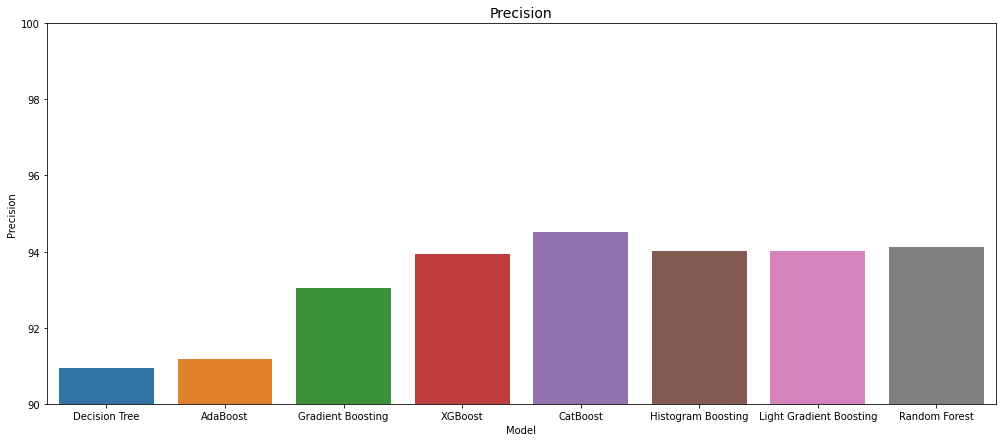

In [23]:
# Precision Comparison
plt.figure(figsize=(17,7))
sns.barplot(x='Model', y='Precision', data=models)
plt.title("Precision", fontsize=14)
plt.ylim(90,100)
plt.show()

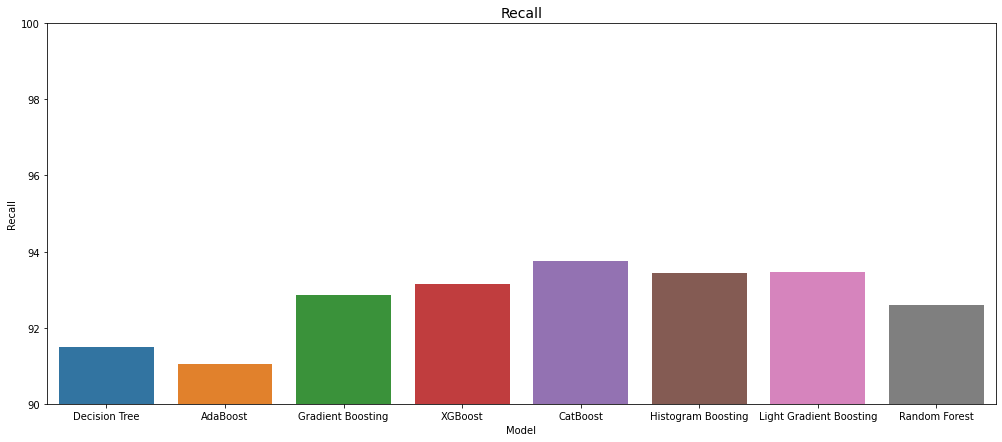

In [24]:
# Recall Comparison
plt.figure(figsize=(17,7))
sns.barplot(x='Model', y='Recall', data=models)
plt.title("Recall", fontsize=14)
plt.ylim(90,100)
plt.show()

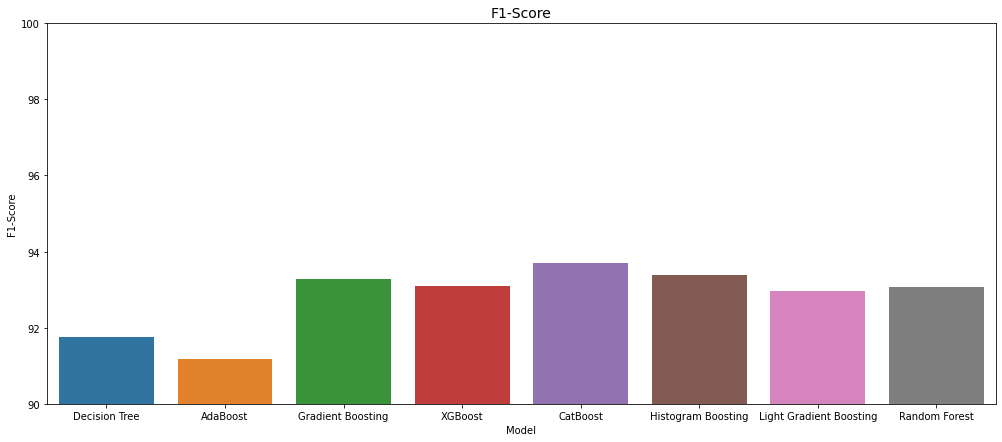

In [25]:
# F1-Score Comparison
plt.figure(figsize=(17,7))
sns.barplot(x='Model', y='F1-Score', data=models)
plt.title("F1-Score", fontsize=14)
plt.ylim(90,100)
plt.show()

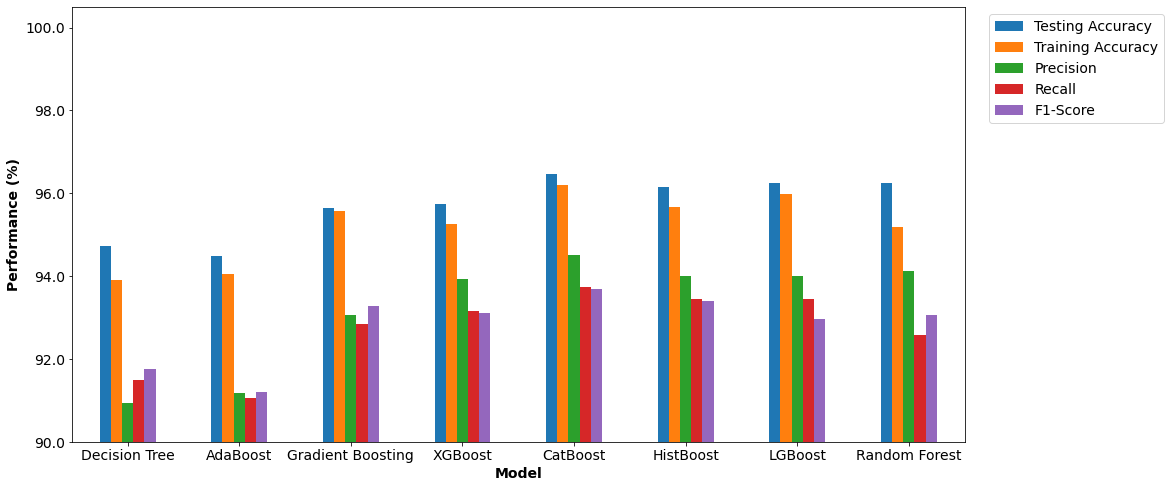

In [26]:
#Comparison Performance Model
new_labels = ['Decision Tree', 'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'HistBoost', 'LGBoost', 'Random Forest']
models.plot(kind="bar", figsize=(16, 8), legend=True)
plt.xlabel("Model", fontdict={'size': 14, 'weight': 'bold'})
plt.xticks(range(len(models)), new_labels, rotation=0, fontsize=14)
plt.ylim(90,100.5)
plt.ylabel("Performance (%)",fontdict={'size': 14, 'weight': 'bold'})
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left')
ax = plt.gca()
ax.set_yticklabels(["{:.1f}".format(y) for y in ax.get_yticks()], fontsize=14) 
plt.show()

***Save Model***

In [27]:
import pickle
pickle.dump(decision_tree, open(r'D:\python\code\CWRU\FIX\Model\decision_tree.sav', 'wb'))
pickle.dump(adaboost, open(r'D:\python\code\CWRU\FIX\Model\AdaBoost.sav', 'wb'))
pickle.dump(xgboost, open(r'D:\python\code\CWRU\FIX\Model\XGBoost.sav', 'wb'))
pickle.dump(catboost, open(r'D:\python\code\CWRU\FIX\Model\CatBoost.sav', 'wb'))
pickle.dump(histboost, open(r'D:\python\code\CWRU\FIX\Model\HistBoost.sav', 'wb'))
pickle.dump(lgbm, open(r'D:\python\code\CWRU\FIX\Model\LGBM.sav', 'wb'))
pickle.dump(GBM, open(r'D:\python\code\CWRU\FIX\Model\GBM.sav', 'wb'))
pickle.dump(random_forest, open(r'D:\python\code\CWRU\FIX\Model\random_forest.sav', 'wb'))